# Duke ML Project - Sparse Array DL
## Title: Model Training Notebook
## Author: Anthony DiSpirito III
## Github: @axd465

### Import Statements

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import imageio.v3 as imageio
import scipy
import pandas as pd
import time
from functools import partial

GPU = 0
GPU_MEM = 32768#None#32768 # in Mb
use_mixed_prec = False#True#False

physical_gpus = tf.config.list_physical_devices('GPU')

if physical_gpus:
    try:
        # Disable GPU
        if GPU is None:
            gpu_id = []
        else:
            gpu_id = physical_gpus[GPU:GPU+1]
        tf.config.set_visible_devices(gpu_id, 'GPU')
        visible_gpus = tf.config.get_visible_devices('GPU')
        # tf.config.experimental.set_memory_growth(*visible_gpus, True)
        print("Num Visible Physical GPUs: ", len(physical_gpus),
              "\nNum Visible GPUs Available: ", len(visible_gpus))
        if GPU is not None and GPU_MEM is not None:
            tf.config.set_logical_device_configuration(
                gpu_id[0],
                [
                    tf.config.LogicalDeviceConfiguration(memory_limit=GPU_MEM),
                    # tf.config.LogicalDeviceConfiguration(memory_limit=10240)
                ]
            )
        logical_gpus = tf.config.list_logical_devices('GPU')
        print(len(visible_gpus), "Visible GPUs,", len(logical_gpus), "Logical GPUs")
        print(f"Visible Devices are: {tf.config.get_visible_devices()}")
        print(f"Logical Devices are: {logical_gpus}")
    except RuntimeError as e:
        # Virtual devices must be set before GPUs have been initialized
        print(e)

%matplotlib inline
%load_ext autoreload
%autoreload 2
MAP_AUTOTUNE = tf.data.AUTOTUNE#int(os.cpu_count()*2/3)#int(os.cpu_count()*1/3)
AUTOTUNE = tf.data.AUTOTUNE
print('Tensorflow version: ' + tf.__version__)

# For Mixed Precision
from tensorflow.keras import mixed_precision
if use_mixed_prec:
    policy = mixed_precision.Policy('mixed_float16')
    mixed_precision.set_global_policy(policy)
    print('Compute dtype: %s' % policy.compute_dtype)
    print('Variable dtype: %s' % policy.variable_dtype)

Num Visible Physical GPUs:  2 
Num Visible GPUs Available:  1
1 Visible GPUs, 1 Logical GPUs
Visible Devices are: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Logical Devices are: [LogicalDevice(name='/device:GPU:0', device_type='GPU')]
Tensorflow version: 2.11.0


In [2]:
TEST_ITER_TIMES = 0

## Creating Dataset:

In [3]:
data_root = "./recon_code/data"
folder_path = os.path.join(data_root, "raw_rfnpy_pa")
seed = 7
file_list = [os.path.join(folder_path, file) for file in os.listdir(folder_path)
             if os.path.isfile(os.path.join(folder_path, file))]
file_list_ds = tf.data.Dataset.from_tensor_slices(file_list).prefetch(AUTOTUNE)
file_list_ds = file_list_ds.shuffle(len(file_list), reshuffle_each_iteration=False, seed=seed).prefetch(AUTOTUNE)

In [4]:
def set_ds_split(ds, training_split=[0.8, 0.1, 0.1]):
    train_split = training_split[0]
    val_split = training_split[1]
    test_split = training_split[2]
    ds_size = tf.data.experimental.cardinality(ds).numpy()
    assert (train_split + test_split + val_split) == 1

    train_size = int(train_split * ds_size)
    val_size = int(val_split * ds_size)

    train_ds = ds.take(train_size)
    val_ds = ds.skip(train_size).take(val_size)
    test_ds = ds.skip(train_size).skip(val_size)

    return train_ds, val_ds, test_ds

In [5]:
training_split = [0.85, 0.15, 0.0]
train_ds, val_ds, test_ds = set_ds_split(file_list_ds, training_split)

In [6]:
test_ds_list = [file.decode('utf-8') for file in test_ds.as_numpy_iterator()]

In [7]:
NUM_TRAIN = tf.data.experimental.cardinality(train_ds).numpy()
NUM_VAL = tf.data.experimental.cardinality(val_ds).numpy()
NUM_TEST = tf.data.experimental.cardinality(test_ds).numpy()

In [8]:
# @tf.function
def load_data(path):
    path = path.decode()
    # Load RF Data
    data = np.load(path)
    return data

In [9]:
@tf.function(reduce_retracing=True)
def lambda_load(item):
    return tf.numpy_function(load_data, [item], tf.float32)

In [10]:
train_ds = train_ds.map(lambda_load,
                        num_parallel_calls=MAP_AUTOTUNE).prefetch(AUTOTUNE)
val_ds = val_ds.map(lambda_load,
                    num_parallel_calls=MAP_AUTOTUNE).prefetch(AUTOTUNE)
if NUM_TEST > 0:
    test_ds = test_ds.map(lambda_load,
                          num_parallel_calls=MAP_AUTOTUNE).prefetch(AUTOTUNE)

In [10]:
# train_ds = tf.data.experimental.from_list(list(train_ds.as_numpy_iterator())).prefetch(AUTOTUNE)
# val_ds = tf.data.experimental.from_list(list(val_ds.as_numpy_iterator())).prefetch(AUTOTUNE)
# test_ds = tf.data.experimental.from_list(list(test_ds.as_numpy_iterator())).prefetch(AUTOTUNE)

In [11]:
if TEST_ITER_TIMES:
    ITERS = 20
    SUBITERS = 20
    times = []
    for i in range(ITERS):
        start = time.time()
        for i, p0_recon in enumerate(iter(train_ds)):
            if i == SUBITERS:
                break
        end = time.time()
        times.append((end-start)/SUBITERS)
    print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
# Was: "Runtime per iter: 11.469977498054504 +/- 0.33286937123295507 ms"

Runtime per iter: 11.469977498054504 +/- 0.33286937123295507 ms


## Form the Sparse Reconstruction Matrix

In [11]:
from python.utils.vol_process_utils import import_mat
import cupy as cp
from cupyx.scipy.sparse import csr_matrix as csr_gpu
from cupyx.scipy.sparse import csc_matrix as csc_gpu
from scipy.sparse import csr_array, csc_array

sparse_mat_dict = import_mat("./recon_code/pa_code/sparse_matrix.mat")

In [12]:
sparse_mat_dict.keys()

dict_keys(['Cols', 'Rows', 'arr_size', 'data', 'interp_scale', 'mat_file_version'])

In [13]:
indices = np.zeros([sparse_mat_dict["Cols"].shape[-1], 2], dtype=np.uint32)
indices[:, 0] = np.array(sparse_mat_dict["Rows"], dtype=np.uint32) - 1
indices[:, 1] = np.array(sparse_mat_dict["Cols"], dtype=np.uint32) - 1
values = np.array(sparse_mat_dict["data"], dtype=np.float16).flatten()
dense_shape = np.array(sparse_mat_dict["arr_size"], dtype=np.uint32).flatten()

In [14]:
M = csc_array((values, (indices[:, 0], indices[:, 1])), shape=dense_shape) #(scipy.sparse.csr_matrix)

In [15]:
M.shape

(2496688, 1966080)

## Interpolating Time Dimension of RF Data

In [16]:
example_data = next(iter(train_ds))
print(example_data.shape)

(1920, 256)


In [17]:
time_interp_scale = [dense_shape[1]/np.prod(example_data.shape), 1.0]
print(time_interp_scale)

[4.0, 1.0]


In [18]:
NEW_SHAPE = [int(shape*time_interp_scale[i])
             for i, shape in enumerate(np.array(example_data.shape))]
UP_METHOD = 'bilinear'
print(f"NEW_SHAPE = {NEW_SHAPE}")
resize_layer = tf.keras.layers.Resizing(height=NEW_SHAPE[0],
                                        width=NEW_SHAPE[1],
                                        interpolation=UP_METHOD)

NEW_SHAPE = [7680, 256]


In [19]:
@tf.function(input_signature=[tf.TensorSpec(example_data.shape)],
             reduce_retracing=True, jit_compile=True)
def interp(rfdata):
    out = rfdata
    out = tf.expand_dims(out, axis=-1)

    out = resize_layer(out)
    # out = tf.image.resize(images=out,
    #                       size=NEW_SHAPE,
    #                       method=UP_METHOD)

    out = tf.squeeze(out)
    return out

In [20]:
train_ds = (
    train_ds
    .map(interp, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(interp, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
if NUM_TEST > 0:
    test_ds = (
        test_ds
        .map(interp, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

In [21]:
example_data = next(iter(train_ds))
print(example_data.shape)

(7680, 256)


In [21]:
if TEST_ITER_TIMES:
    ITERS = 20
    SUBITERS = 20
    times = []
    for i in range(ITERS):
        start = time.time()
        for i, p0_recon in enumerate(iter(train_ds)):
            if i == SUBITERS:
                break
        end = time.time()
        times.append((end-start)/SUBITERS)
    print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
    # Timing is about 40ms with smaller stddev when num_parallel_calls=1 for interp map
# Was: "Runtime per iter: 48.79143238067627 +/- 3.9089137289246887 ms"

Runtime per iter: 48.79143238067627 +/- 3.9089137289246887 ms


## Setup Reconstruction Functions and Test to See an Example Reconstructed Volume Pre-Augmentation

In [22]:
@tf.function(input_signature=[tf.TensorSpec(example_data.shape)],
             jit_compile=True)
def recon_data_prep(rfdata):
    out = rfdata
    out = tf.reshape(tf.transpose(out), [-1])[..., tf.newaxis]
    out = tf.cast(out, dtype=tf.float16)
    return out

In [23]:
def reconstruct(x,
                M_gpu,
                out_shape=[134, 137, 136],
                gpu_id=GPU,
                reshape=False):
    with cp.cuda.Device(gpu_id):
        x_gpu = cp.array(x)
        out = M_gpu.dot(x_gpu)
        if reshape:
            out = cp.reshape(out, newshape=out_shape)
            out = out.T
        x_gpu = None
    out = out.get()
    out = tf.cast(out, tf.float32)
    return out

In [24]:
RECON_SHAPE = [134, 137, 136] # transpose of Matlab version
GPU_RESHAPE = 0

if GPU_RESHAPE:
    signature = [tf.TensorSpec(np.flip(RECON_SHAPE), dtype=tf.float32),
                               tf.TensorSpec([3,], dtype=tf.int32),
                               tf.TensorSpec([], dtype=tf.bool)]
else:
    signature = [tf.TensorSpec([np.prod(RECON_SHAPE), None], dtype=tf.float32),
                                tf.TensorSpec([3,], dtype=tf.int32),
                                tf.TensorSpec([], dtype=tf.bool)]
@tf.function(input_signature=signature)
def post_recon_process(x, out_shape=[134, 137, 136], reshape=True):
    out = x
    if reshape:
        out = tf.reshape(out, shape=out_shape)
        out = tf.transpose(out)
    out = tf.cast(out, tf.float32)
    return out

In [25]:
if 'M_gpu' not in locals():
    with cp.cuda.Device(GPU):
        M_gpu = csc_gpu(M)

    print("Allocated M_gpu")

recon = partial(reconstruct,
                M_gpu=M_gpu,
                gpu_id=GPU,
                out_shape=RECON_SHAPE,
                reshape=GPU_RESHAPE)
post_recon = partial(post_recon_process,
                     out_shape=RECON_SHAPE,
                     reshape=(not GPU_RESHAPE))

Allocated M_gpu


In [26]:
@tf.function(input_signature=[tf.TensorSpec([np.prod(example_data.shape), None], dtype=tf.float16)])
def lambda_recon(item):
    return tf.numpy_function(recon, [item], tf.float32)

In [27]:
M_gpu.shape

(2496688, 1966080)

In [28]:
recon_train_ds = (
    train_ds
    .map(recon_data_prep, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_recon, num_parallel_calls=3)
    .prefetch(AUTOTUNE)
    .map(post_recon, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [29]:
example = next(iter(recon_train_ds))

In [30]:
example.shape

TensorShape([136, 137, 134])

In [31]:
if TEST_ITER_TIMES:
    ITERS = 10
    SUBITERS = 25
    times = []
    for i in range(ITERS):
        start = time.time()
        for i, p0_recon in enumerate(iter(recon_train_ds)):
            if i == SUBITERS:
                break
        end = time.time()
        times.append((end-start)/SUBITERS)
    print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
# Was: "Runtime per iter: 122.66659069061278 +/- 4.303657993554564 ms"

Runtime per iter: 122.66659069061278 +/- 4.303657993554564 ms


15.447003
-15.788482


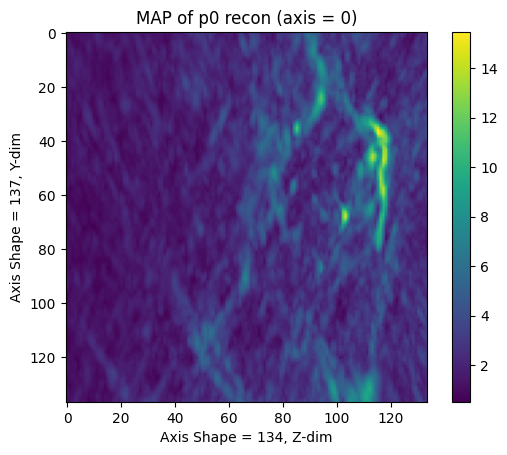

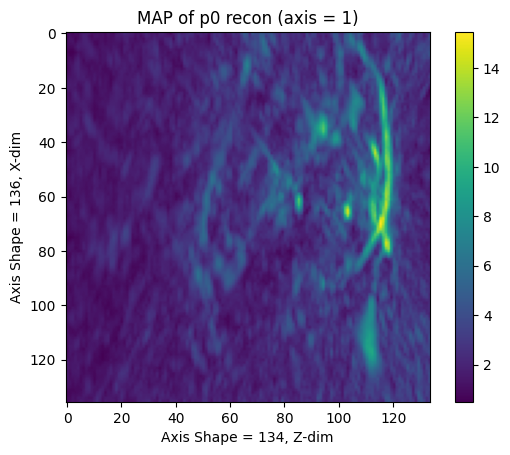

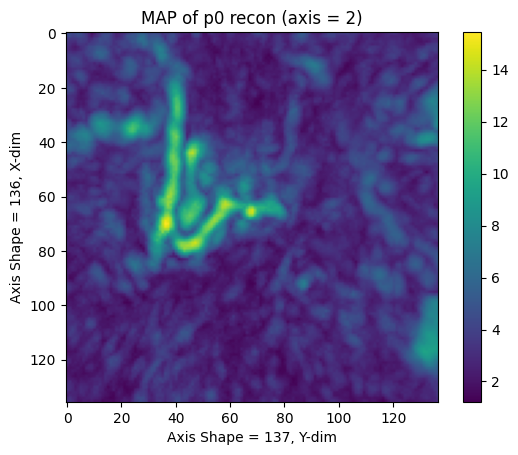

In [34]:
axis_map = {136: "X-dim",
            137: "Y-dim",
            134: "Z-dim"}
print(np.max(p0_recon))
print(np.min(p0_recon))
for i in range(len(p0_recon.shape)):
    map_axis = i
    map_img = tf.math.reduce_max(p0_recon, axis=map_axis)
    plt.imshow(map_img)
    plt.title(f"MAP of p0 recon (axis = {map_axis})")
    # plt.axis("off")
    plt.ylabel(f"Axis Shape = {map_img.shape[0]}, {axis_map[map_img.shape[0]]}")
    plt.xlabel(f"Axis Shape = {map_img.shape[1]}, {axis_map[map_img.shape[1]]}")
    plt.colorbar()
    plt.show()

## Creating Input Pipeline

### Input Pipeline (Pre Reconstruction)

In [31]:
from python.utils.augmentation_utils import (augment, keras_augment, 
                                             normalize, batch_augment_noise)
INIT_SEED = 7
norm_range = [-1, 1]
PROB_OF_AUG = 1/2#1/3 # prob [0,1]
MAX_BRIGHT_SHIFT = 0.1#0.1 # in range [0,1]
LOWER_CONTRAST_FACTOR = 0.75#0.5#0.75
UPPER_CONTRAST_FACTOR = 1.25#1.5#1.25

GAUSS_NOISE_MEAN = 0
LOWER_GAUSS_NOISE_STD = 0.005
UPPER_GAUSS_NOISE_STD = 0.25#0.05#0.25

In [32]:
main_augment = partial(augment,
                       prob=PROB_OF_AUG,
                       max_shift=MAX_BRIGHT_SHIFT,
                       con_factor_range=[LOWER_CONTRAST_FACTOR,
                                         UPPER_CONTRAST_FACTOR],
                       out_range=norm_range,
                       seed=INIT_SEED)

secondary_augment = partial(batch_augment_noise,
                            prob=PROB_OF_AUG/4,
                            mean=GAUSS_NOISE_MEAN,
                            std_lower=LOWER_GAUSS_NOISE_STD,
                            std_upper=UPPER_GAUSS_NOISE_STD,
                            out_range=norm_range,
                            seed=INIT_SEED)

In [33]:
train_ds = (
    train_ds
    .map(main_augment, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(secondary_augment, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)

In [45]:
if TEST_ITER_TIMES:
    ITERS = 10
    SUBITERS = 20
    times = []
    for i in range(ITERS):
        start = time.time()
        for i, p0_recon in enumerate(iter(train_ds)):
            if i == SUBITERS:
                break
        end = time.time()
        times.append((end-start)/SUBITERS)
    print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
# Was: "Runtime per iter: 71.65912389755248 +/- 10.562743212692462 ms"

Runtime per iter: 71.65912389755248 +/- 10.562743212692462 ms


### Input Pipeline (Downsample and Reconstruction)

In [34]:
def downsample(x, down_ratio=[1, 3], start_elem=0, seed=7):
    AXIS = 0
    # rng = np.random.default_rng(seed)
    start_elem += int(tf.random.uniform(shape=(),
                                        minval=start_elem,
                                        maxval=down_ratio[-1],
                                        dtype=tf.int32))
    x = tf.expand_dims(x, axis=AXIS)
    mask = np.zeros(x.shape, dtype = np.float32)
    mask[..., ::down_ratio[0], start_elem::down_ratio[1]] = 1
    down = x * mask
    x = tf.concat((x, down), axis=AXIS)
    return x

In [35]:
DOWN_RATIO = [1, 2]
START_ELEM = 0
undersample = partial(downsample,
                      down_ratio=DOWN_RATIO,
                      start_elem=START_ELEM,
                      seed=INIT_SEED)

In [36]:
@tf.function(input_signature=[tf.TensorSpec(example_data.shape, dtype=tf.float32)])
def lambda_down(item):
    return tf.numpy_function(undersample, [item], tf.float32)

In [37]:
@tf.function(input_signature=[tf.TensorSpec([2, *example_data.shape.as_list()]),
                              tf.TensorSpec([], dtype=tf.bool)],
             jit_compile=True)
def batch_recon_data_prep(rfdata, batch_mode=False):
    out = rfdata
    if batch_mode:
        out = tf.transpose(out)
        out = tf.reshape(out, [-1, rfdata.shape[0]])
    else:
        out = tf.reshape(tf.transpose(out), [-1])[..., tf.newaxis]
    out = tf.cast(out, dtype=tf.float16)
    return out

In [38]:
RECON_SHAPE = [134, 137, 136, 2] # transpose of Matlab version

if GPU_RESHAPE:
    signature = [tf.TensorSpec(np.flip(RECON_SHAPE), dtype=tf.float32),
                               tf.TensorSpec([3,], dtype=tf.int32),
                               tf.TensorSpec([], dtype=tf.bool)]
else:
    signature = [tf.TensorSpec([np.prod(RECON_SHAPE), None], dtype=tf.float32),
                                tf.TensorSpec([3,], dtype=tf.int32),
                                tf.TensorSpec([], dtype=tf.bool)]
def post_recon_process(x, out_shape=[134, 137, 136], reshape=True):
    out = x
    if reshape:
        out = tf.reshape(out, shape=out_shape)
        out = tf.transpose(out)
    out = tf.cast(out, tf.float32)
    return out

In [39]:
batch_recon_data_prep_map = partial(batch_recon_data_prep, batch_mode=True)
post_recon = partial(post_recon_process,
                     out_shape=RECON_SHAPE,
                     reshape=True)

In [40]:
train_ds = (
    train_ds
    .map(lambda_down, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(batch_recon_data_prep_map, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_recon, num_parallel_calls=3)
    .prefetch(AUTOTUNE)
    .map(post_recon, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(lambda_down, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(batch_recon_data_prep_map, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(lambda_recon, num_parallel_calls=3)
    .prefetch(AUTOTUNE)
    .map(post_recon, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
if NUM_TEST > 0:
    test_ds = (
        test_ds
        .map(lambda_down, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(batch_recon_data_prep_map, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
        .map(lambda_recon, num_parallel_calls=3)
        .prefetch(AUTOTUNE)
        .map(post_recon, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

In [41]:
test = next(iter(train_ds))
test.shape

TensorShape([2, 136, 137, 134])

(136, 137, 134)
4.2067537
-4.1501427


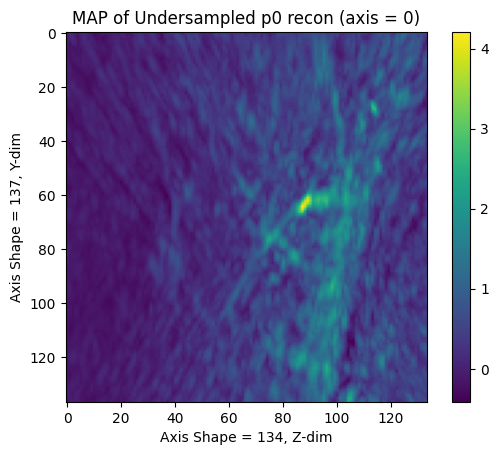

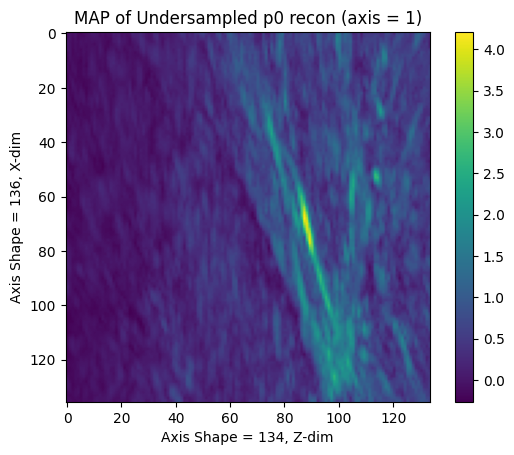

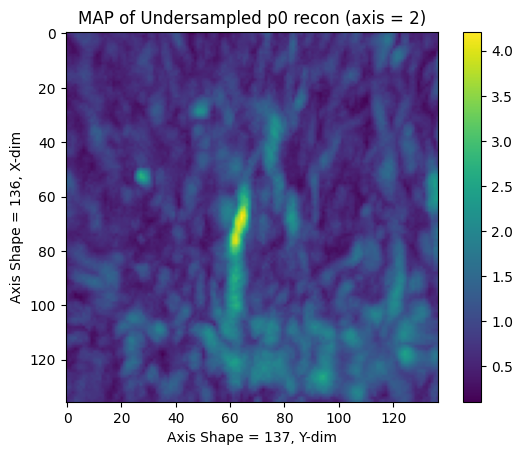

In [45]:
p0_recon = test[1, ...]
print(p0_recon.shape)
axis_map = {136: "X-dim",
            137: "Y-dim",
            134: "Z-dim"}
print(np.max(p0_recon))
print(np.min(p0_recon))
for i in range(len(p0_recon.shape)):
    map_axis = i
    map_img = tf.math.reduce_max(p0_recon, axis=map_axis)
    plt.imshow(map_img)
    plt.title(f"MAP of Undersampled p0 recon (axis = {map_axis})")
    # plt.axis("off")
    plt.ylabel(f"Axis Shape = {map_img.shape[0]}, {axis_map[map_img.shape[0]]}")
    plt.xlabel(f"Axis Shape = {map_img.shape[1]}, {axis_map[map_img.shape[1]]}")
    plt.colorbar()
    plt.show()

8.353773
-8.647611


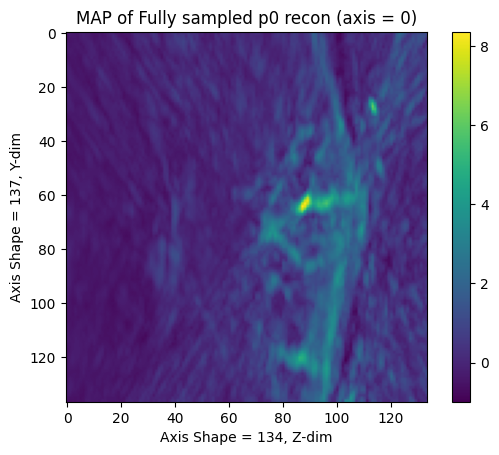

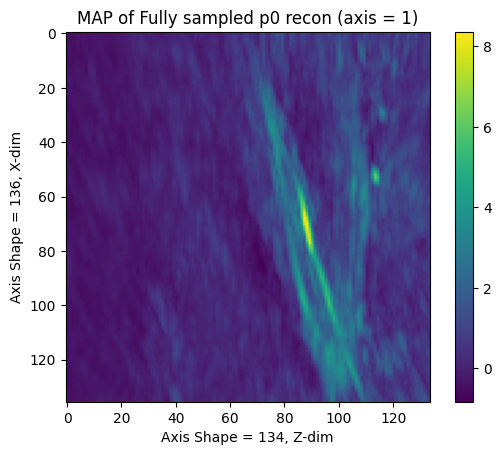

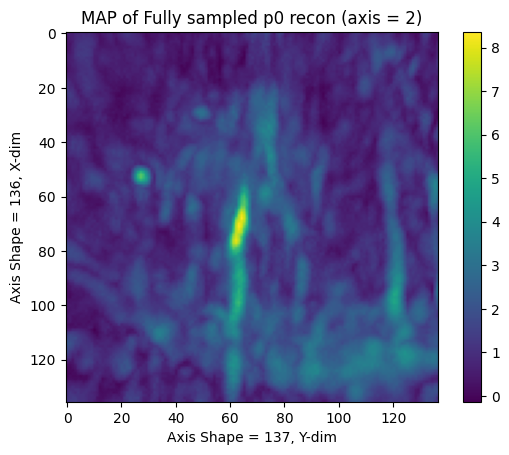

In [46]:
p0_recon = test[0, ...]
axis_map = {136: "X-dim",
            137: "Y-dim",
            134: "Z-dim"}
print(np.max(p0_recon))
print(np.min(p0_recon))
for i in range(len(p0_recon.shape)):
    map_axis = i
    map_img = tf.math.reduce_max(p0_recon, axis=map_axis)
    plt.imshow(map_img)
    plt.title(f"MAP of Fully sampled p0 recon (axis = {map_axis})")
    # plt.axis("off")
    plt.ylabel(f"Axis Shape = {map_img.shape[0]}, {axis_map[map_img.shape[0]]}")
    plt.xlabel(f"Axis Shape = {map_img.shape[1]}, {axis_map[map_img.shape[1]]}")
    plt.colorbar()
    plt.show()

In [56]:
ITERS = 10
SUBITERS = 25
times = []
for i in range(ITERS):
    start = time.time()
    for i, p0_recon in enumerate(iter(train_ds)):
        if i == SUBITERS:
            break
    end = time.time()
    times.append((end-start)/SUBITERS)
    print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
# Was: "Runtime per iter: 337.9843654632569 +/- 10.509843555891516 ms"

Runtime per iter: 337.9843654632569 +/- 10.509843555891516 ms


### Input Pipeline (Post Batch Reconstruction)

In [42]:
vol_shape = next(iter(train_ds)).shape
print(vol_shape)
CROP_SIZE = [2, 128, 128, 128]
MAX_SHIFT_FRACTION_X_Y_Z = [0.1, 0.1, 0.1]

FLIP_MODE = "horizontal_and_vertical"

ROT_FACTOR = [0.2, 0.2, 0.2]
INTERP = 'bilinear'
FILL_MODE = 'reflect'
FILL_VALUE = 0.0
ROT_KWARGS = {
    "interpolation": INTERP,
    "fill_mode": FILL_MODE,
    "seed": INIT_SEED,
    "fill_value": FILL_VALUE
}

(2, 136, 137, 134)


In [43]:
def get_flip_layer(mode=FLIP_MODE, seed=INIT_SEED):
    flip_layer = tf.keras.layers.RandomFlip(mode=FLIP_MODE,
                                            seed=seed)
    return flip_layer


FLIP_LAYER = get_flip_layer(FLIP_MODE, INIT_SEED)

@tf.function(reduce_retracing=True, jit_compile=True)
def rand_flip_3d(x, prob=PROB_OF_AUG, seed=INIT_SEED):
    flip_layer = FLIP_LAYER

    out = x

    rand_var = tf.random.uniform(shape=(), seed=seed)
    if rand_var < prob:
        out = flip_layer(x)

        out = tf.transpose(out, perm=[0, 2, 3, 1])
        out = flip_layer(out)
        out = tf.transpose(out, perm=[0, 3, 1, 2])

        out = tf.transpose(out, perm=[0, 1, 3, 2])
        out = flip_layer(out)
        out = tf.transpose(out, perm=[0, 1, 3, 2])

    return out

In [44]:
@tf.function(reduce_retracing=True)
def rand_transpose_3d(x, prob=PROB_OF_AUG, seed=INIT_SEED):
    out = x
    rand_var = tf.random.uniform(shape=(), seed=seed)
    if rand_var < prob:
        out = tf.transpose(out, perm=tf.concat([tf.constant([0]), tf.random.shuffle([1, 2, 3])], axis=0))
    return out

In [45]:
def get_rot_layers(rot_factor=ROT_FACTOR, rot_kwargs=ROT_KWARGS):
    rot_xy_layer = tf.keras.layers.RandomRotation(rot_factor[0],
                                                  **rot_kwargs)
    rot_yz_layer = tf.keras.layers.RandomRotation(rot_factor[1],
                                                  **rot_kwargs)
    rot_xz_layer = tf.keras.layers.RandomRotation(rot_factor[2],
                                                  **rot_kwargs)
    return (rot_xy_layer, rot_yz_layer, rot_xz_layer)


ROT_LAYERS = get_rot_layers(ROT_FACTOR, ROT_KWARGS)


@tf.function(reduce_retracing=True)
def rand_rot_3d(x, prob=PROB_OF_AUG, seed=INIT_SEED):
    recon_shape = np.flip(RECON_SHAPE)
    rot_xy_layer, rot_yz_layer, rot_xz_layer = ROT_LAYERS

    out = x

    rand_var = tf.random.uniform(shape=(), seed=seed)
    if rand_var < prob:

        # Rotation of XY Plane
        out = tf.concat([out[0, ...],
                         out[1, ...]],
                        axis=-1)
        out = rot_xy_layer(out)
        out = tf.stack([out[..., :recon_shape[3]],
                        out[..., recon_shape[3]:]],
                       axis=0)

        # Rotation of XZ Plane
        out = tf.transpose(out, perm=[0, 1, 3, 2])
        out = tf.concat([out[0, ...],
                         out[1, ...]],
                        axis=-1)
        out = rot_xz_layer(out)
        out = tf.stack([out[..., :recon_shape[2]],
                        out[..., recon_shape[2]:]],
                       axis=0)
        out = tf.transpose(out, perm=[0, 1, 3, 2])

        # Rotation of YZ Plane
        out = tf.transpose(out, perm=[0, 2, 3, 1])
        out = tf.concat([out[0, ...],
                         out[1, ...]],
                        axis=-1)
        out = rot_yz_layer(out)
        out = tf.stack([out[..., :recon_shape[1]],
                        out[..., recon_shape[1]:]],
                       axis=0)
        out = tf.transpose(out, perm=[0, 3, 1, 2])

    return out

In [46]:
zero_pad = partial(tf.pad,
                   paddings=[
                       [0, 0],
                       [int(np.ceil(vol_shape[1]*MAX_SHIFT_FRACTION_X_Y_Z[0]/2)+1),
                        int(np.ceil(vol_shape[1]*MAX_SHIFT_FRACTION_X_Y_Z[0]/2)+1)],
                       [int(np.ceil(vol_shape[2]*MAX_SHIFT_FRACTION_X_Y_Z[1]/2)+1),
                        int(np.ceil(vol_shape[2]*MAX_SHIFT_FRACTION_X_Y_Z[1]/2)+1)],
                       [int(np.ceil(vol_shape[3]*MAX_SHIFT_FRACTION_X_Y_Z[2]/2)+1),
                        int(np.ceil(vol_shape[3]*MAX_SHIFT_FRACTION_X_Y_Z[2]/2)+1)],
                   ],
                   mode='CONSTANT',
                   constant_values=0)

rand_crop = partial(tf.image.random_crop, size=CROP_SIZE)

random_flip_3d = partial(rand_flip_3d, prob=PROB_OF_AUG, seed=INIT_SEED)

random_transpose_3d = partial(rand_transpose_3d, prob=PROB_OF_AUG, seed=INIT_SEED)

random_rotate_3d = partial(rand_rot_3d, prob=PROB_OF_AUG, seed=INIT_SEED)

In [47]:
# pre_aug_train_ds = train_ds
# train_ds = pre_aug_train_ds

In [47]:
train_ds = (
    train_ds
    # .map(random_flip_3d, num_parallel_calls=MAP_AUTOTUNE)
    # .prefetch(AUTOTUNE)
    # .map(random_rotate_3d, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    # .map(random_transpose_3d, num_parallel_calls=MAP_AUTOTUNE)
    # .prefetch(AUTOTUNE)
    .map(zero_pad, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
    .map(rand_crop, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(rand_crop, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
if NUM_TEST > 0:
    test_ds = (
        test_ds
        .map(rand_crop, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

In [63]:
ITERS = 5
SUBITERS = 25
times = []
for i in range(ITERS):
    start = time.time()
    for i, p0_recon in enumerate(iter(train_ds)):
        if i == SUBITERS:
            break
    end = time.time()
    times.append((end-start)/SUBITERS)
print(f"Runtime per iter: {np.mean(times)/1e-3} +/- {np.std(times)/1e-3} ms")
# Was: "Runtime per iter: 356.8940200805664 +/- 15.20680163975501 ms"

Runtime per iter: 356.8940200805664 +/- 15.20680163975501 ms


In [48]:
vol = next(iter(train_ds))

In [49]:
vol.shape

TensorShape([2, 128, 128, 128])

In [50]:
print(np.min(vol[0, ...]))
print(np.max(vol[0, ...]))
print(np.mean(vol[0, ...]))

print(np.min(vol[1, ...]))
print(np.max(vol[1, ...]))
print(np.mean(vol[1, ...]))

-0.7317605
17.5393
7.6695504
-0.6388196
8.97068
3.8341925


In [51]:
img_gt = np.max(vol[0, ...], axis=1)
img_down = np.max(vol[1, ...], axis=1)

In [52]:
print(np.min(img_gt))
print(np.max(img_gt))
print(np.mean(img_gt))

print(np.min(img_down))
print(np.max(img_down))
print(np.mean(img_down))

7.672218
17.5393
9.111803
3.9477463
8.97068
4.863532


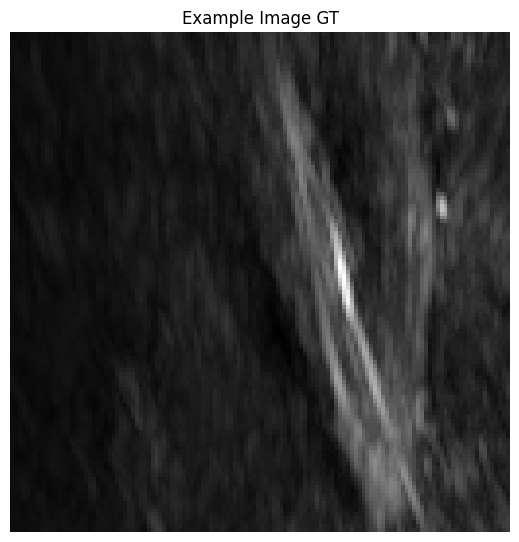

In [53]:
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
im = ax.imshow(img_gt, cmap='gray')
plt.title('Example Image GT')
plt.show()

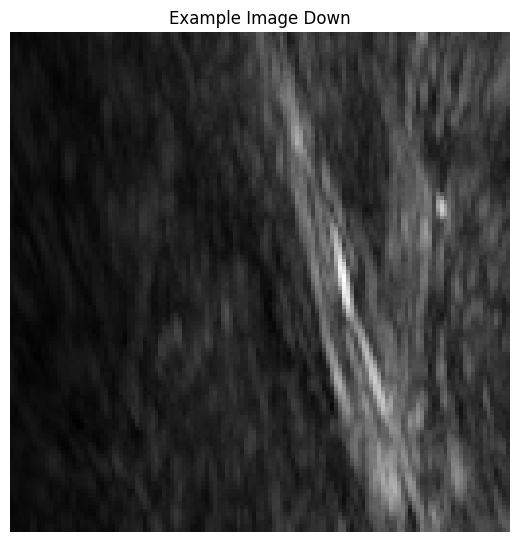

In [54]:
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_down, cmap='gray')
plt.title('Example Image Down')
plt.show()

## Define Model Input and Ground Truth

In [55]:
def define_in_out_func(x):
    gt = tf.squeeze(x[0, ...])
    gt = tf.expand_dims(gt, axis=-1)
    down = tf.squeeze(x[1, ...])
    down = tf.expand_dims(down, axis=-1)
    return down, gt

In [56]:
train_ds = (
    train_ds
    .map(define_in_out_func, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .map(define_in_out_func, num_parallel_calls=MAP_AUTOTUNE)
    .prefetch(AUTOTUNE)
)
if NUM_TEST > 0:
    test_ds = (
        test_ds
        .map(define_in_out_func, num_parallel_calls=MAP_AUTOTUNE)
        .prefetch(AUTOTUNE)
    )

In [57]:
down_vol, gt_vol = next(iter(train_ds))

In [58]:
print(gt_vol.shape)
print(down_vol.shape)

(128, 128, 128, 1)
(128, 128, 128, 1)


In [59]:
img_gt = np.max(gt_vol, axis=1)
img_down = np.max(down_vol, axis=1)

# img_gt = np.rot90(img_gt, -1)
# img_down = np.rot90(img_down, -1)

In [60]:
print(np.min(img_gt))
print(np.max(img_gt))
print(np.mean(img_gt))

print(np.min(img_down))
print(np.max(img_down))
print(np.mean(img_down))

6.10002
15.833065
7.5253344
3.1925647
7.9480467
3.9676301


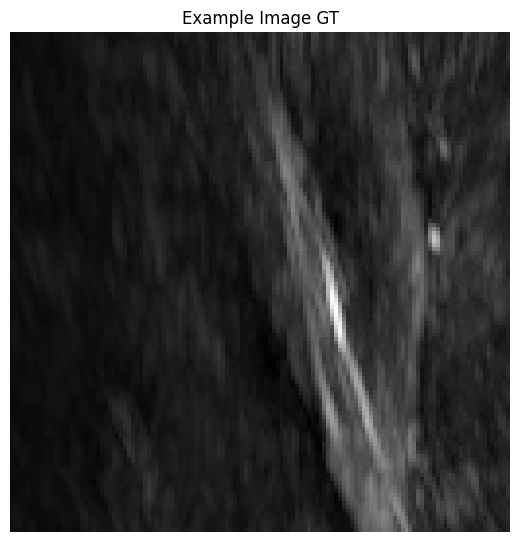

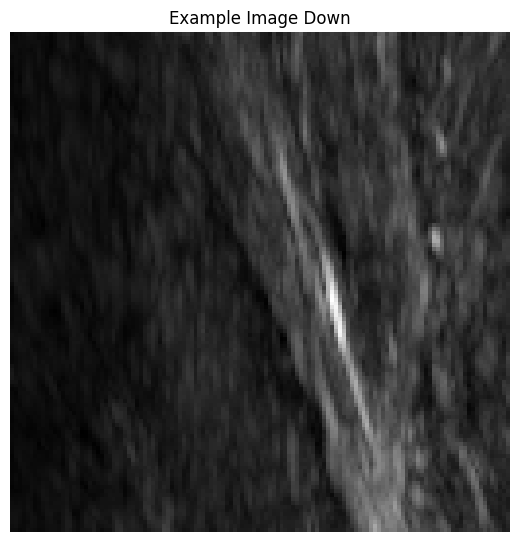

In [61]:
figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_gt, cmap='gray')
plt.title('Example Image GT')
plt.show()

figsize = (5, 5)
fig = plt.figure(figsize=figsize)
ax = fig.add_axes([0, 0, 1, 1])
ax.axis('off')
ax.imshow(img_down, cmap='gray')
plt.title('Example Image Down')
plt.show()

## Model Training:

In [62]:
from tensorflow.keras.layers import BatchNormalization, LayerNormalization

# Hyperparameters:
INPUT_SHAPE = [None, None, None, 1]
KERNEL_SIZE = 5
DILATION_RATE = 2
BATCH_SIZE = 2#1#32#16#8
EPOCHS = 150#25#250
FILTERS = 16#8#32#32#32#32#4#8#32
ACTIVATION = "gelu"#"relu"#"gelu"#"elu"#"relu"
PADDING = 'same'
INTERP_UP = True
STRIDED_CONV = True
KERNEL_REGULARIZER =  None#tf.keras.regularizers.L2(0.0001)
BIAS_REGULARIZER =  None#tf.keras.regularizers.L2(0.00005)
ACTIVITY_REGULARIZER = None
KERNEL_INITIALIZER = "he_normal"#"orthogonal"#"lecun_normal"#"glorot_normal"
DROP_PROB = 0.2#0.05#0.05#0#0.15
NORMALIZATION_LAYER = LayerNormalization
INITIAL_LR = 0.002
WARMUP = 10
LR_DECAY = 0.5
LR_DECAY_START = 10
AUGMENTATIONS = 5#10#5
VAL_AUGMENTATIONS = 10#10
EPS = 1e-12
PATIENCE = 20#25#50
MIN_DELTA = 1e-2#1e-4 # change to 1e-2 next time
MIN_LR = INITIAL_LR/1000

LOSS_KWARGS = {
    "B1": 1.0,
    "B2": 0.0,#5e-10,
}
USE_MS_SSIM = False # Using MSSSIM loss results in NaN gradients
PIXELWISE_LOSS = tf.keras.losses.MeanAbsoluteError()#tf.keras.losses.MeanSquaredError()#tf.keras.losses.MeanAbsoluteError()

MODEL_DIR = f'saved_models_{GPU}'
UPDATE_INFO_EVERY_X_EPOCHS = 12#25
delete_previous = True
SAVE_METRIC = 'val_loss'

MODEL_NAME = f"3D_UNet"
from python.models.unet_no_id.model_func import DL_Model_Func

In [63]:
from python.utils.loss_utils import PSNR, SSIM, model_loss
custom_loss_func = model_loss(pixelwise_loss=PIXELWISE_LOSS, **LOSS_KWARGS)

In [64]:
kwargs = {
    "input_shape": INPUT_SHAPE,
    "filters": FILTERS,
    "kernel_size": KERNEL_SIZE,
    "activation": ACTIVATION,
    "padding": PADDING,
    "drop_prob": DROP_PROB,
    "norm_layer": NORMALIZATION_LAYER,
    "kernel_initializer": KERNEL_INITIALIZER,
    "kernel_regularizer": KERNEL_REGULARIZER,
    "bias_regularizer": BIAS_REGULARIZER,
    "activity_regularizer": ACTIVITY_REGULARIZER,
    "dilation_rate": DILATION_RATE,
    "strided_conv": STRIDED_CONV,
    "interp_up": INTERP_UP,
    # "loss_kwargs": LOSS_KWARGS,
    "model_name": MODEL_NAME,
    "dl_model_func": DL_Model_Func,
}

In [65]:
train_ds = (
    train_ds
    .prefetch(AUTOTUNE)
    .shuffle(NUM_TRAIN)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)
val_ds = (
    val_ds
    .prefetch(AUTOTUNE)
    .shuffle(NUM_VAL)
    .batch(BATCH_SIZE)
    .repeat()
    .prefetch(AUTOTUNE)
)

In [66]:
# Import Model:
if use_mixed_prec:
    from python.models.dl_model import DL_Model
else:
    from python.models.dl_model import DL_Model

model = DL_Model(**kwargs)

In [87]:
model.model.summary()

Model: "DL_Model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 in_img (InputLayer)            [(None, None, None,  0           []                               
                                 None, 1)]                                                        
                                                                                                  
 conv3d (Conv3D)                (None, None, None,   2016        ['in_img[0][0]']                 
                                None, 16)                                                         
                                                                                                  
 layer_normalization (LayerNorm  (None, None, None,   32         ['conv3d[0][0]']                 
 alization)                     None, 16)                                                  

In [67]:
optimizer = tf.keras.optimizers.Adam(learning_rate=INITIAL_LR, amsgrad=True)
# tf.config.optimizer.set_jit(True)
if use_mixed_prec:
    optimizer = mixed_precision.LossScaleOptimizer(optimizer)
model.compile(optimizer=optimizer,
              loss=custom_loss_func,#PIXELWISE_LOSS,
              steps_per_execution=((AUGMENTATIONS) * np.ceil(NUM_TRAIN/BATCH_SIZE)) // UPDATE_INFO_EVERY_X_EPOCHS,
              metrics=['mean_absolute_error', 'mean_squared_error'],
              # jit_compile=True,
              # run_eagerly=True,
             )

In [68]:
#############################################################################################################
if LR_DECAY_START < WARMUP:
    LR_DECAY_START = WARMUP

def scheduler(epoch, lr):
    if epoch == 0:
        return MIN_LR
    elif epoch <= WARMUP:
        return (epoch/WARMUP)*INITIAL_LR
    else:
        return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

#############################################################################################################
from python.utils.model_save_monkey_patch import ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=SAVE_METRIC,
                                                 factor=LR_DECAY,
                                                 min_delta=MIN_DELTA,
                                                 patience=PATIENCE,
                                                 min_lr=MIN_LR,
                                                 delay_start=LR_DECAY_START)

#############################################################################################################
from python.utils.model_save_monkey_patch import ModelCheckpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR, 
                                                                            'saved_model-epoch_{epoch:02d}-' + 
                                                                            SAVE_METRIC + '_{' + 
                                                                            SAVE_METRIC + ':.10f}.h5'),
                                                      monitor=SAVE_METRIC,
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode='min',
                                                      save_freq='epoch')
#############################################################################################################

In [ ]:
if not os.path.exists(MODEL_DIR):
    os.mkdir(MODEL_DIR)
elif delete_previous:
    shutil.rmtree(MODEL_DIR)
    os.mkdir(MODEL_DIR)

tmp_dir = "./tmp"
if not os.path.exists(tmp_dir):
    os.mkdir(tmp_dir)
elif delete_previous:
    shutil.rmtree(tmp_dir)
    os.mkdir(tmp_dir)
log_dir = tmp_dir#"./tmp/tmpw42q7x43"#tempfile.mkdtemp(dir=tmp_dir)


backup = tf.keras.callbacks.BackupAndRestore(backup_dir=os.path.join(log_dir, "backup"))


my_callbacks = [model_checkpoint, reduce_lr, backup, lr_schedule]


history = model.fit(train_ds,
                    steps_per_epoch=int(AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE)),
                    epochs=EPOCHS,
                    callbacks=my_callbacks,
                    validation_data=val_ds,
                    validation_steps=int(VAL_AUGMENTATIONS*np.ceil(NUM_VAL/BATCH_SIZE)),
                    max_queue_size=100000*AUGMENTATIONS*np.ceil(NUM_TRAIN/BATCH_SIZE),
                    use_multiprocessing=True,
                    workers=8,
                   )

Epoch 1/150
510/510 [==============================] - 1156s 2s/step - loss: 6.1918 - mean_absolute_error: 6.1918 - mean_squared_error: 90.8574 - val_loss: 0.9716 - val_mean_absolute_error: 0.9716 - val_mean_squared_error: 1.6681 - lr: 2.0000e-06
Epoch 2/150
510/510 [==============================] - 1077s 2s/step - loss: 4.8710 - mean_absolute_error: 4.8710 - mean_squared_error: 62.6683 - val_loss: 0.6137 - val_mean_absolute_error: 0.6137 - val_mean_squared_error: 0.9741 - lr: 2.0000e-04
Epoch 3/150
510/510 [==============================] - 1076s 2s/step - loss: 4.6585 - mean_absolute_error: 4.6585 - mean_squared_error: 59.5215 - val_loss: 0.9413 - val_mean_absolute_error: 0.9413 - val_mean_squared_error: 1.4038 - lr: 4.0000e-04
Epoch 4/150
510/510 [==============================] - 1076s 2s/step - loss: 4.0711 - mean_absolute_error: 4.0711 - mean_squared_error: 45.6453 - val_loss: 0.5954 - val_mean_absolute_error: 0.5954 - val_mean_squared_error: 0.9103 - lr: 6.0000e-04
Epoch 5/150


In [ ]:
# 3D_UNet
from python.utils.history_utils import show_history
offset = 0
show_history(history, offset)

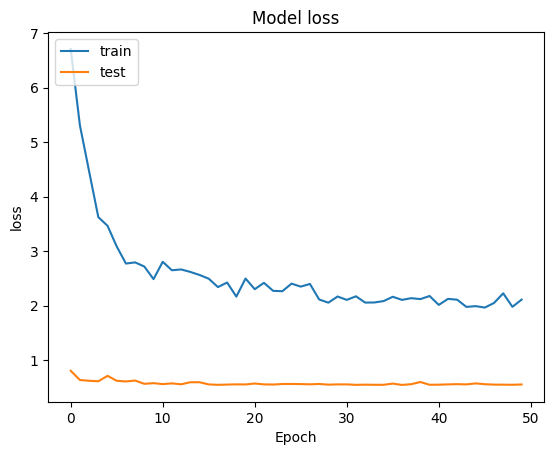

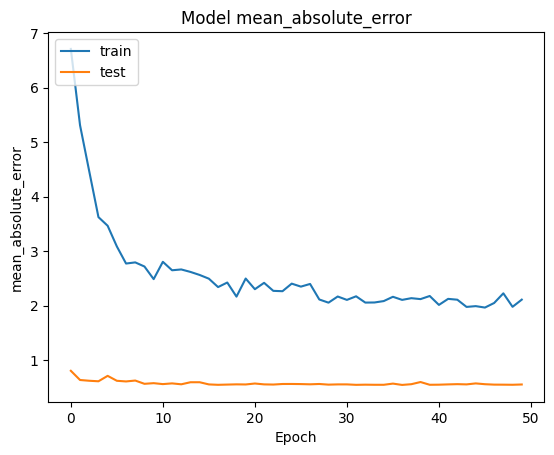

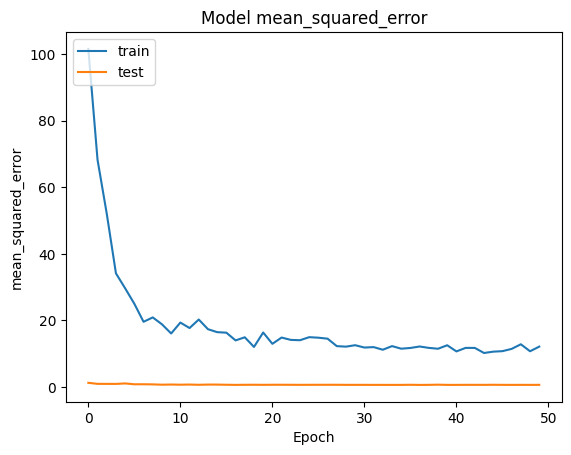

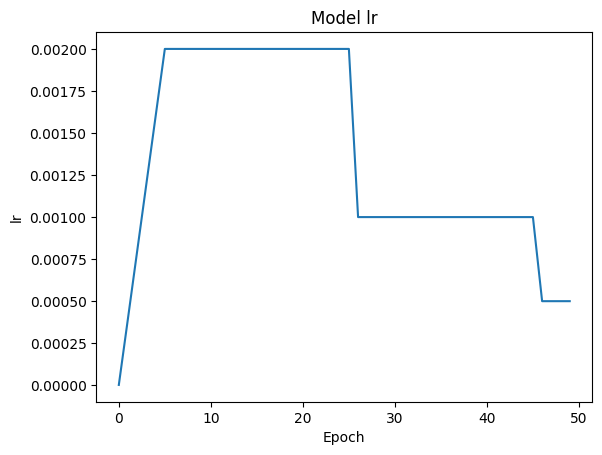

In [72]:
# 3D_UNet
from python.utils.history_utils import show_history
offset = 0
show_history(history, offset)

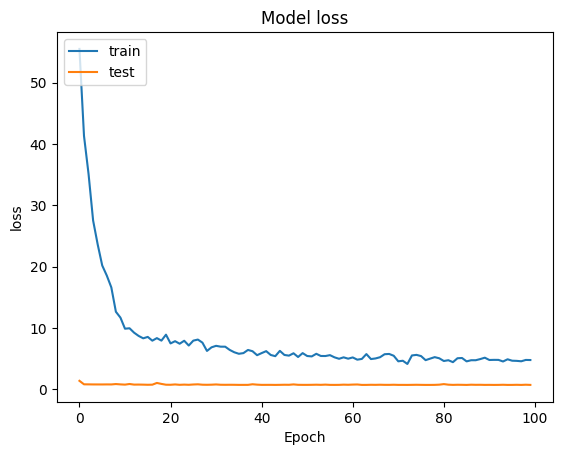

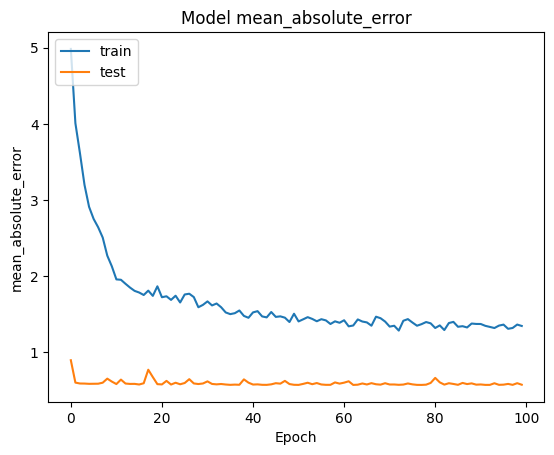

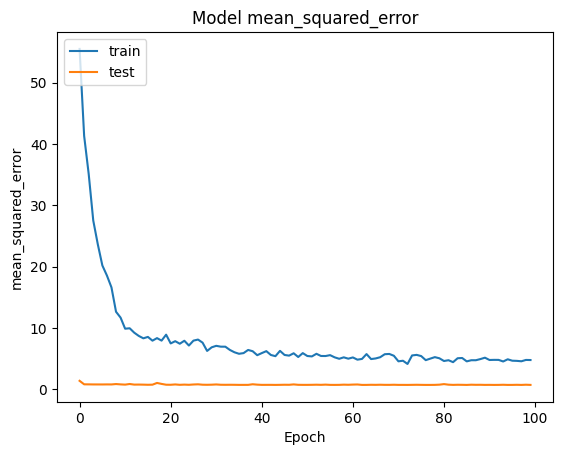

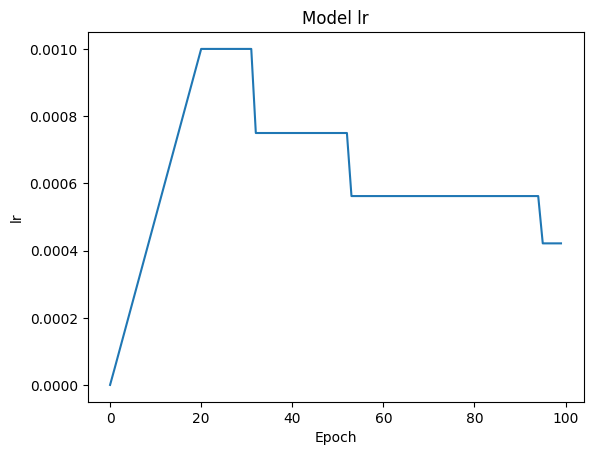

In [66]:
# 3D_UNet
from python.utils.history_utils import show_history
offset = 0
show_history(history, offset)

### Save Model and History into Folder

In [73]:
description = '''
Description:
3D UNet - just MAE

# Hyperparameters:
INPUT_SHAPE = [None, None, None, 1]
KERNEL_SIZE = 3
DILATION_RATE = 1
BATCH_SIZE = 2#1#32#16#8
EPOCHS = 50#25#250
FILTERS = 16#8#32#32#32#32#4#8#32
ACTIVATION = "gelu"#"relu"#"gelu"#"elu"#"relu"
PADDING = 'same'
INTERP_UP = True
STRIDED_CONV = True
KERNEL_REGULARIZER =  None#tf.keras.regularizers.L2(0.0001)
BIAS_REGULARIZER =  None#tf.keras.regularizers.L2(0.00005)
ACTIVITY_REGULARIZER = None
KERNEL_INITIALIZER = "he_normal"#"orthogonal"#"lecun_normal"#"glorot_normal"
DROP_PROB = 0.2#0.05#0.05#0#0.15
NORMALIZATION_LAYER = LayerNormalization
INITIAL_LR = 0.002
WARMUP = 5
LR_DECAY = 0.5
LR_DECAY_START = 10
AUGMENTATIONS = 5#10#5
VAL_AUGMENTATIONS = 10#10
EPS = 1e-12
PATIENCE = 10#25#50
MIN_DELTA = 1e-4 # change to 1e-2 next time
MIN_LR = INITIAL_LR/1000

LOSS_KWARGS = {
}
USE_MS_SSIM = False # Using MSSSIM loss results in NaN gradients
PIXELWISE_LOSS = tf.keras.losses.MeanAbsoluteError()#tf.keras.losses.MeanSquaredError()#tf.keras.losses.MeanAbsoluteError()

MODEL_DIR = f'saved_models_{GPU}'
UPDATE_INFO_EVERY_X_EPOCHS = 12#25
delete_previous = True
SAVE_METRIC = 'val_loss'

MODEL_NAME = f"3D_UNet"
from python.models.unet_no_id.model_func import DL_Model_Func

#############################################################################################################
if LR_DECAY_START < WARMUP:
    LR_DECAY_START = WARMUP

def scheduler(epoch, lr):
    if epoch == 0:
        return MIN_LR
    elif epoch <= WARMUP:
        return (epoch/WARMUP)*INITIAL_LR
    else:
        return lr

lr_schedule = tf.keras.callbacks.LearningRateScheduler(scheduler)

#############################################################################################################
from python.utils.model_save_monkey_patch import ReduceLROnPlateau
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor=SAVE_METRIC,
                                                 factor=LR_DECAY,
                                                 min_delta=MIN_DELTA,
                                                 patience=PATIENCE,
                                                 min_lr=MIN_LR,
                                                 delay_start=LR_DECAY_START)

#############################################################################################################
from python.utils.model_save_monkey_patch import ModelCheckpoint
model_checkpoint = tf.keras.callbacks.ModelCheckpoint(filepath=os.path.join(MODEL_DIR, 
                                                                            'saved_model-epoch_{epoch:02d}-' + 
                                                                            SAVE_METRIC + '_{' + 
                                                                            SAVE_METRIC + ':.10f}.h5'),
                                                      monitor=SAVE_METRIC,
                                                      verbose=0,
                                                      save_best_only=True,
                                                      save_weights_only=False,
                                                      mode='min',
                                                      save_freq='epoch')
#############################################################################################################

'''
from python.utils.history_utils import save_history
save_last_x_best_models = 2

if not os.path.exists('./trained_models'):
    os.mkdir('./trained_models')
output_dir = f'trained_models/saved_{model.name.lower()}_gpu{GPU}'

if not os.path.exists(output_dir):
    print(f'Creating New Directory at {output_dir}...')
    os.mkdir(output_dir)
else:
    print('Directory Already Exists...')
    output_dir += '_v1'
    while os.path.exists(output_dir):
        v_num = int(output_dir[-5:].partition('_v')[-1])
        output_dir = output_dir.partition(f'_v{v_num}')[0]
        v_num += 1
        output_dir += f'_v{v_num}'
    print(f'Creating New Directory at {output_dir}...')
    os.mkdir(output_dir)
final_val_loss = history.history['val_loss'][-1]
model.model.save(os.path.join(output_dir, f'saved_model-epoch_{EPOCHS}-val_loss_{final_val_loss:0.10f}.h5'))
best_model_dir = os.path.join(output_dir, 'best_models')
if not os.path.exists(best_model_dir):
    os.mkdir(best_model_dir)
print('Saving Best Model(s)...')
for i in range(save_last_x_best_models):
    file_list = [file for file in os.listdir(MODEL_DIR) if os.path.isfile(os.path.join(MODEL_DIR, file))]
    filename = sorted(file_list, key=lambda x: int(x.partition('h_')[2].partition('-')[0]))[-1]
    old_path = os.path.join(MODEL_DIR, filename)
    new_path = os.path.join(best_model_dir, filename)
    os.rename(old_path, new_path)
print('Saving History...')
save_history(history, output_dir)
print('Saving Description...')
with open(os.path.join(output_dir, "description.txt"), "a") as f:
    f.write(description)
print('Done!!!')

Directory Already Exists...
Creating New Directory at trained_models/saved_3d_unet_gpu0_v1...
Saving Best Model(s)...
Saving History...
Saving Description...
Done!!!
